In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist
import pandas as pd

In [2]:
import sys
from pathlib import Path
import os 

project_root = Path.cwd().parents[1]  
sys.path.append(str(project_root))
os.chdir(project_root)

In [3]:
from explainability.explaination_config import ExplainationConfig
config = ExplainationConfig("biomining")
feature_name = config.feature_names
print(feature_name)

['ABL1', 'ABL1b', 'CSF1R', 'CSF1Rb', 'EGFR', 'EGFRb', 'FLT1', 'FLT1b', 'FLT4', 'FLT4b', 'KDR', 'KDRb', 'KIT', 'KITb', 'MCL1', 'MCL1b', 'NR1I2', 'NR1I2b', 'PDGFRB', 'PDGFRBb', 'RET', 'RETb', 'TOP2A', 'TOP2Ab', 'TUBB1', 'TUBB1b', 'GATA3', 'NF1', 'NF2', 'P53', 'PI3K', 'PTEN', 'RAS']


In [4]:
SAVE_PATH = "explainability/ig/results/biomining_integrated_gradients_mean.pt"
all_attributions = torch.load(SAVE_PATH, weights_only=False)

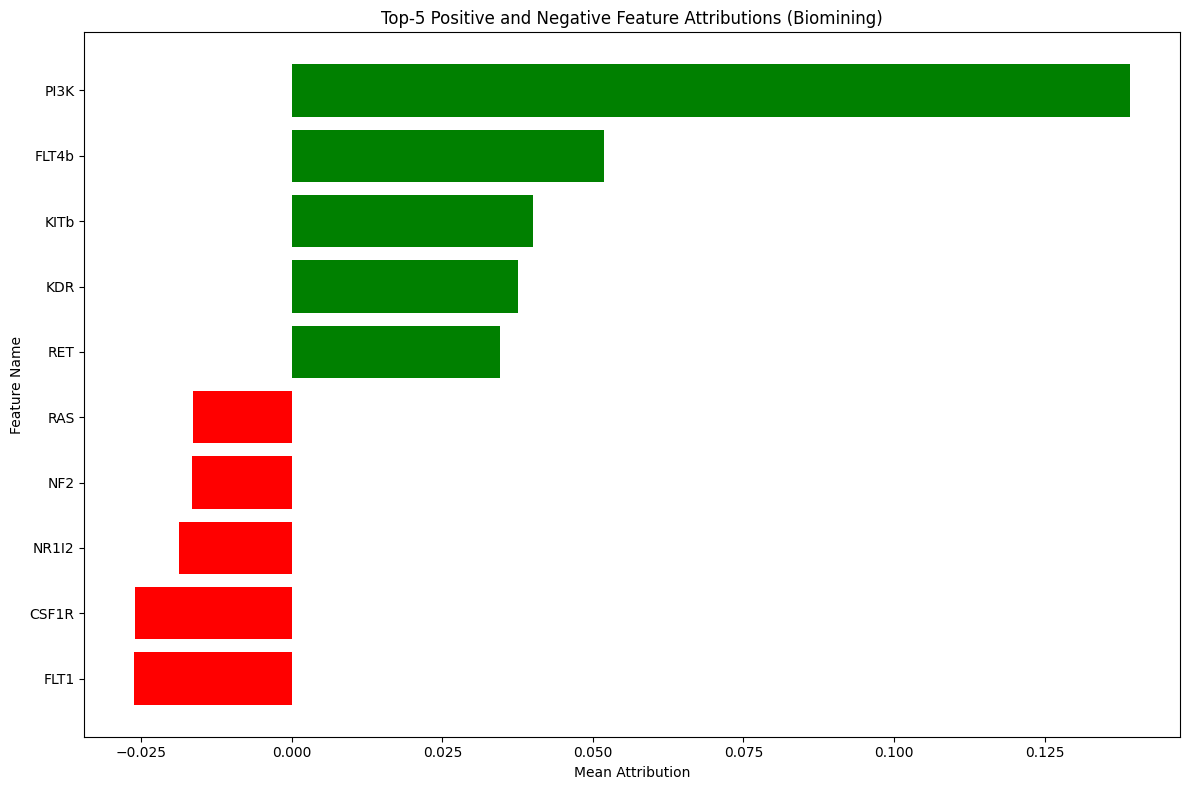

In [5]:
mean_attributions = all_attributions.mean(dim=0).squeeze().numpy()  
indices = np.argsort(mean_attributions)
top_negative = indices[:5]  
top_positive = indices[-5:]  
top_indices = np.concatenate([top_negative, top_positive])
feature_values = mean_attributions[top_indices]
feature_labels = [feature_name[i] for i in top_indices]
plt.figure(figsize=(12, 8))
plt.barh(feature_labels, feature_values, color=np.where(np.array(feature_values) < 0, 'red', 'green'))
plt.title("Top-5 Positive and Negative Feature Attributions (Biomining)")
plt.xlabel("Mean Attribution")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()
plt.close()

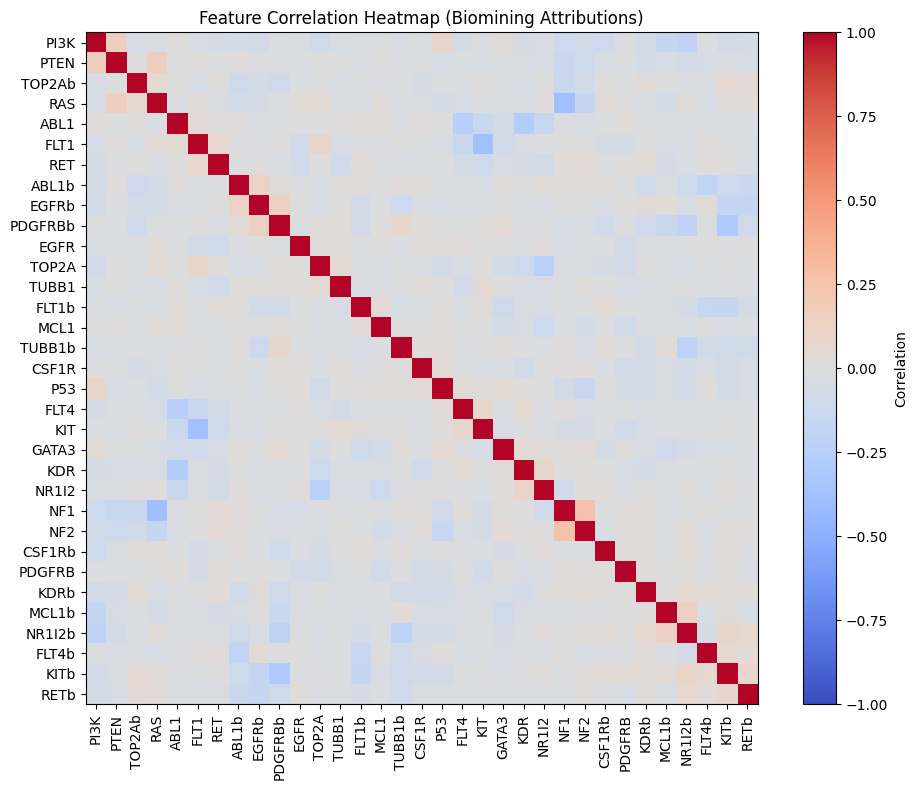

In [6]:
attributions_np = all_attributions.squeeze().numpy()  

variances = np.var(attributions_np, axis=0)
valid_indices = np.where(variances > 0)[0]
attributions_np_filtered = attributions_np[:, valid_indices]
feature_cols_filtered = [feature_name[i] for i in valid_indices]

correlation_matrix = np.corrcoef(attributions_np_filtered, rowvar=False) 
linkage_matrix = linkage(pdist(correlation_matrix), method='average')
order = leaves_list(linkage_matrix)
reordered_matrix = correlation_matrix[np.ix_(order, order)]
reordered_labels = [feature_cols_filtered[i] for i in order]
plt.figure(figsize=(10, 8))
plt.imshow(reordered_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(reordered_labels)), reordered_labels, rotation=90)
plt.yticks(range(len(reordered_labels)), reordered_labels)
plt.title("Feature Correlation Heatmap (Biomining Attributions)")
plt.tight_layout()
plt.show()


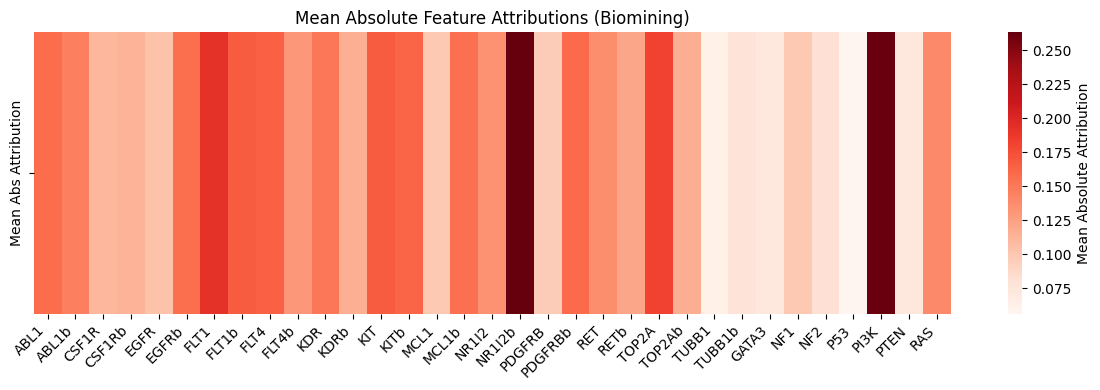

In [7]:
mean_abs_attributions = np.abs(all_attributions.squeeze().numpy()).mean(axis=0)  # Shape: [33]

plt.figure(figsize=(12, 4))
sns.heatmap(
    mean_abs_attributions.reshape(1, -1),
    cmap='Reds',
    xticklabels=feature_name,
    yticklabels=['Mean Abs Attribution'],
    cbar_kws={'label': 'Mean Absolute Attribution'},
)
plt.title("Mean Absolute Feature Attributions (Biomining)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


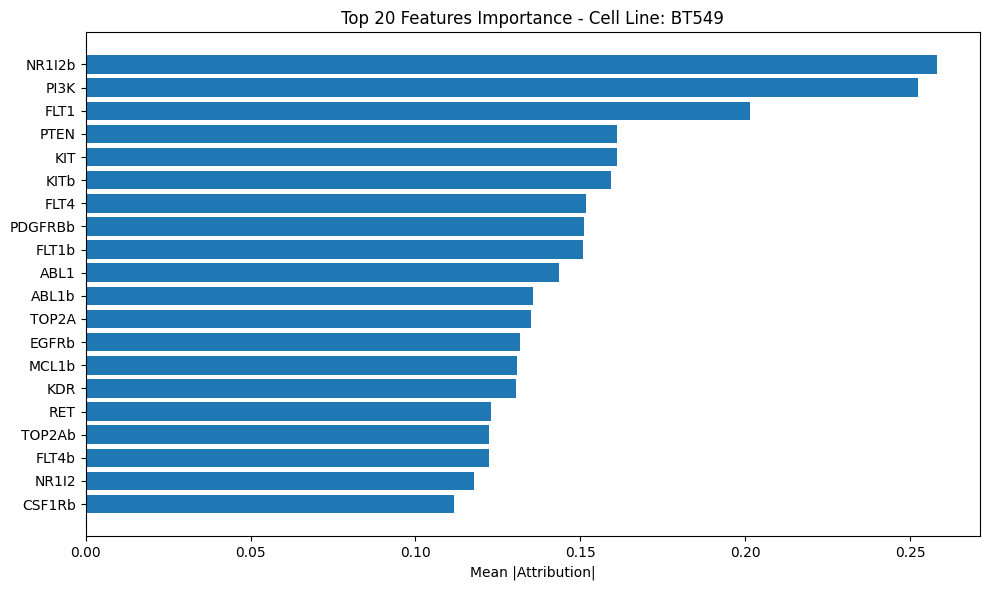

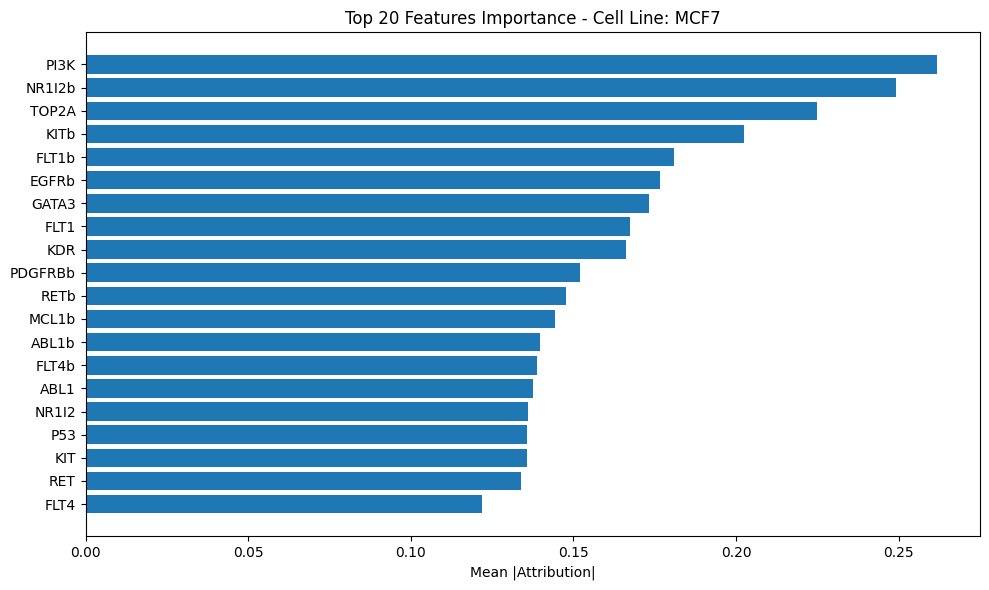

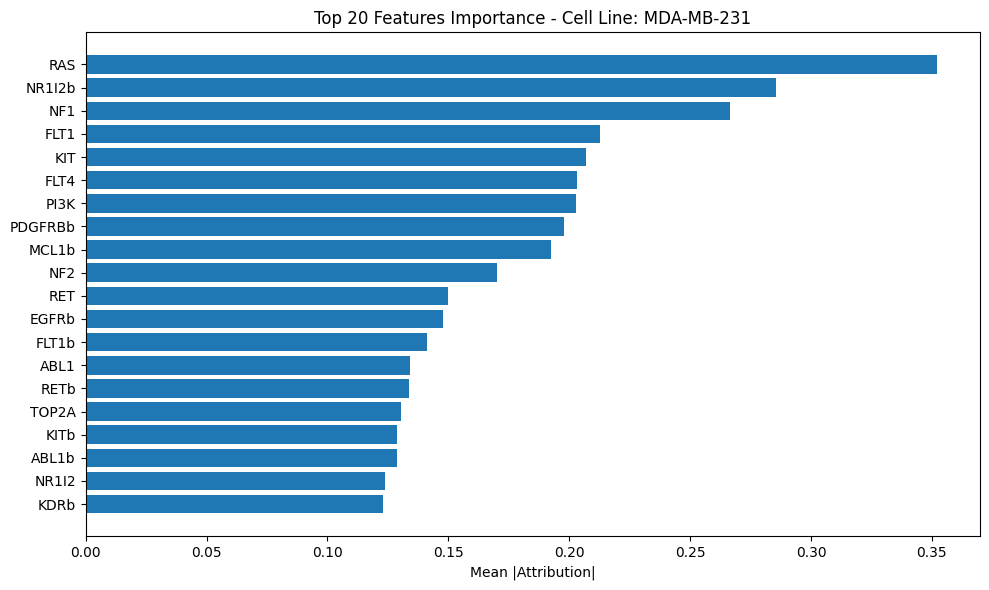

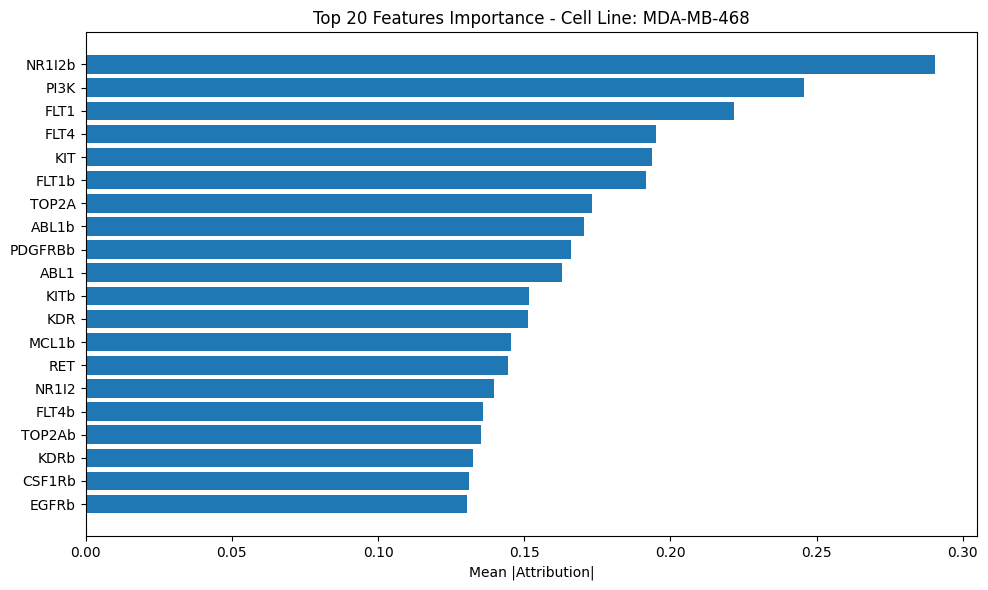

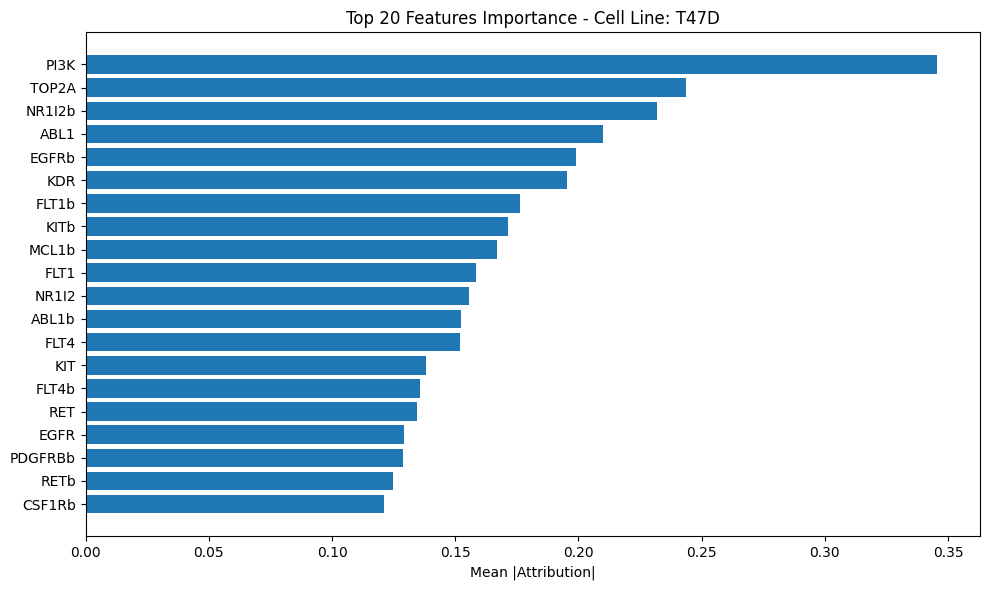

In [8]:
from explainability.data_utils import load_biomining_cell_line_data

def plot_feature_importance_by_cell_line(all_attributions, feature_names, top_n=20):
    cell_lines = load_biomining_cell_line_data(split='train')
    unique_cell_lines = np.unique(cell_lines)

    for cell_line in unique_cell_lines:
        cell_line_indices = np.where(cell_lines == cell_line)[0]
        cell_line_attributions = all_attributions[cell_line_indices]
        
        mean_abs_attributions = np.mean(np.abs(cell_line_attributions), axis=0)
        
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_attribution": mean_abs_attributions
        }).sort_values(by="mean_abs_attribution", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_attribution"][::-1])
        plt.xlabel("Mean |Attribution|")
        plt.title(f"Top {top_n} Features Importance - Cell Line: {cell_line}")
        plt.tight_layout()
        plt.show()


# Convert the attributions to a NumPy array for easier manipulation
all_attributions_np = all_attributions.squeeze().numpy()

plot_feature_importance_by_cell_line(all_attributions_np, feature_name)



## ! From here on  Transynergy !

In [10]:
config = ExplainationConfig("transynergy")
feature_name = config.feature_names
print(feature_name)

Index(['GDF5_A', 'NCOA3_A', 'NRIP1_A', 'AMER1_A', 'LZTR1_A', 'ABL1_A',
       'CLTCL1_A', 'ABL2_A', 'ACACB_A', 'ZRSR2_A',
       ...
       'NETO2_CL', 'VANGL1_CL', 'ARID2_CL', 'TCL1A_CL', 'SLC4A10_CL',
       'SLC7A5_CL', 'TAF15_CL', 'ELL_CL', 'OR2A2_CL', 'pIC50_CL'],
      dtype='object', length=7206)


In [11]:
SAVE_PATH = "explainability/ig/results/transynergy_integrated_gradients_shuffled.pt"
all_attributions = torch.load(SAVE_PATH, weights_only=False)

invalid value encountered in divide
invalid value encountered in divide


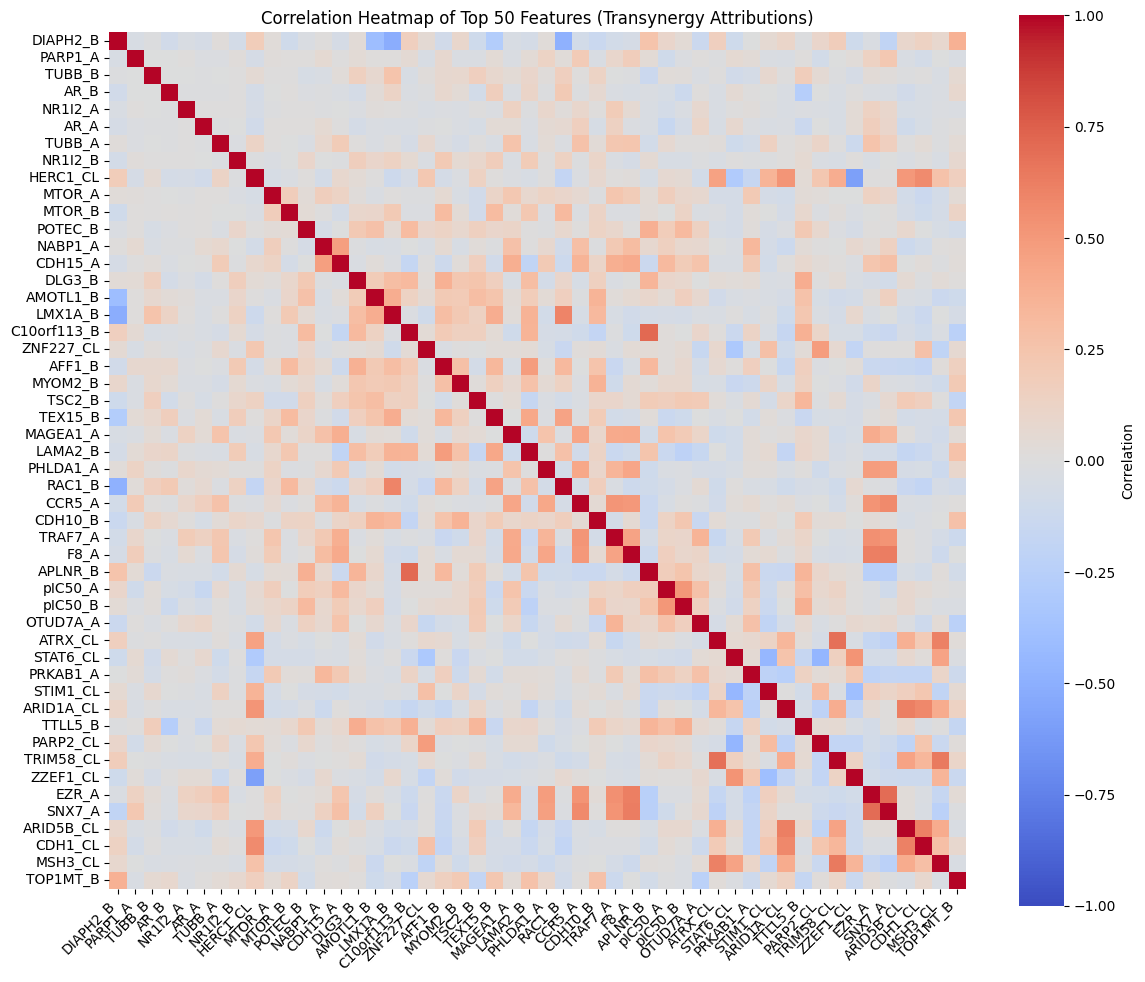

In [12]:
N = all_attributions.shape[0]
attributions_reshaped = all_attributions.squeeze(1).reshape(N, -1)  
attributions_np = attributions_reshaped.numpy()
correlation_matrix = np.corrcoef(attributions_np, rowvar=False)  

mean_attributions = np.abs(attributions_np).mean(axis=0)
top_k_indices = np.argsort(mean_attributions)[-50:]  # Select top 50 features
top_k_features = [feature_name[i] for i in top_k_indices]
correlation_subset = correlation_matrix[top_k_indices][:, top_k_indices]
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_subset,
    xticklabels=top_k_features,
    yticklabels=top_k_features,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
)
plt.title("Correlation Heatmap of Top 50 Features (Transynergy Attributions)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()
plt.close()

[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


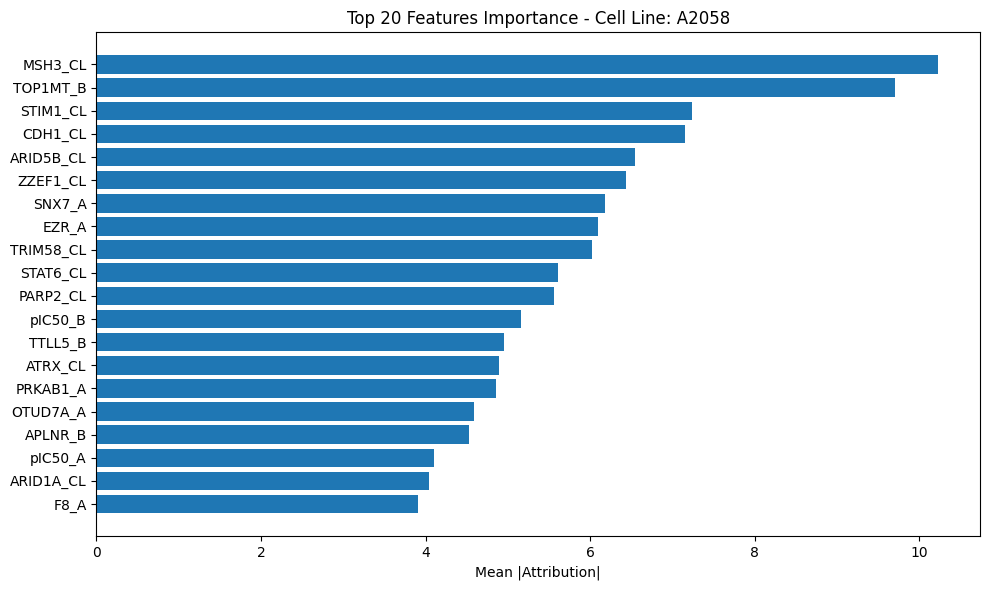

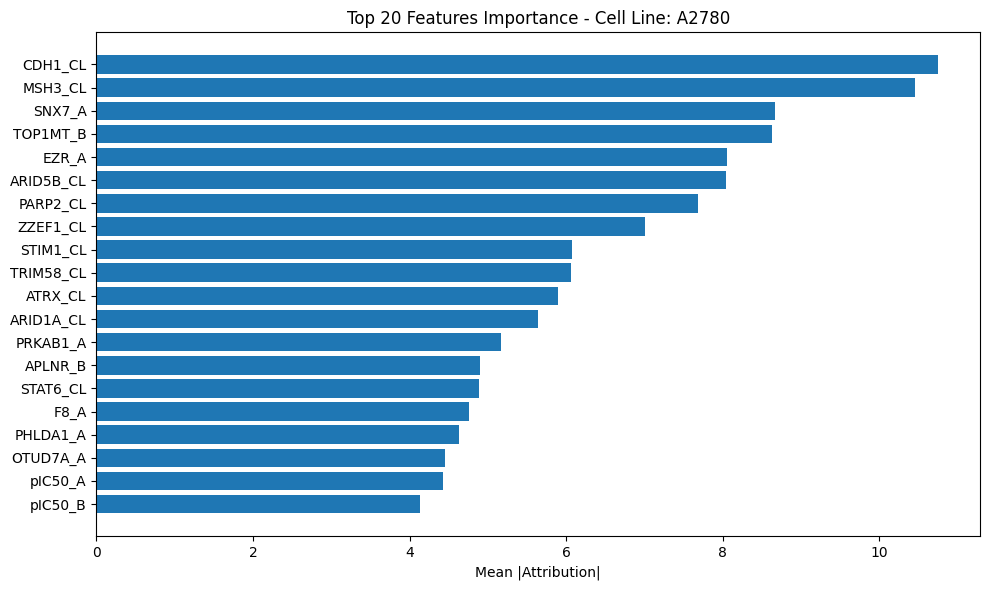

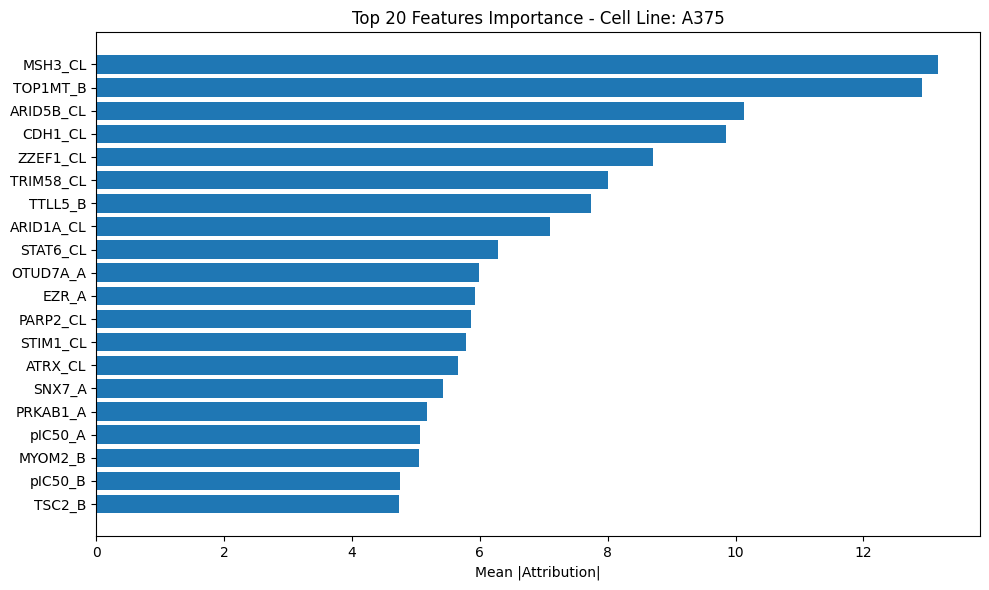

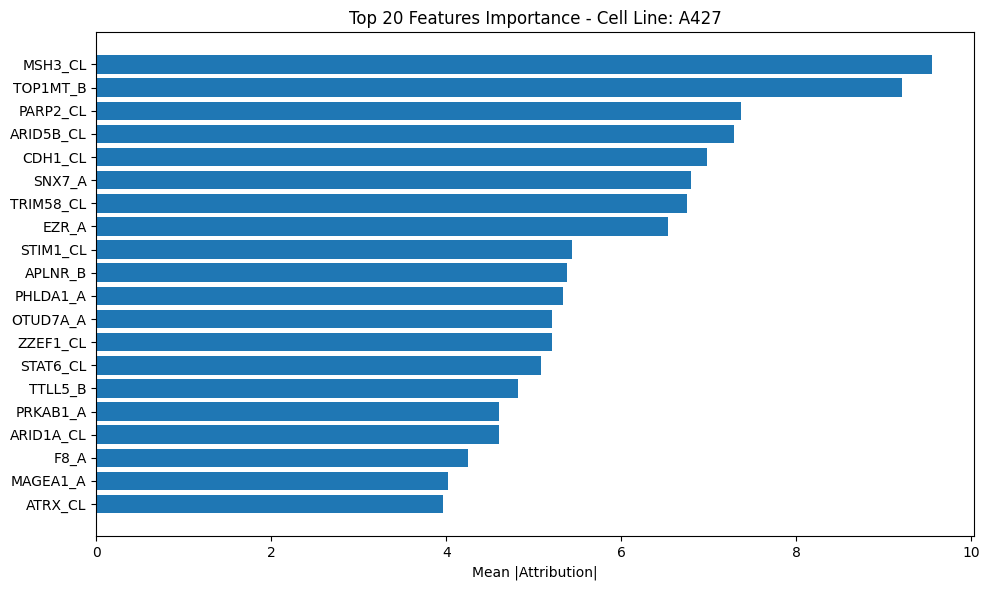

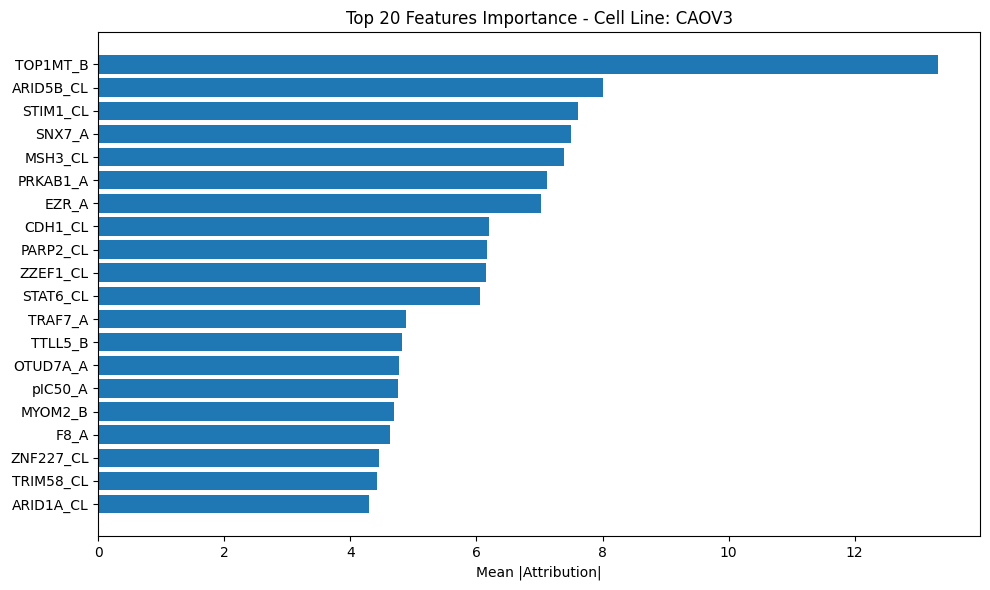

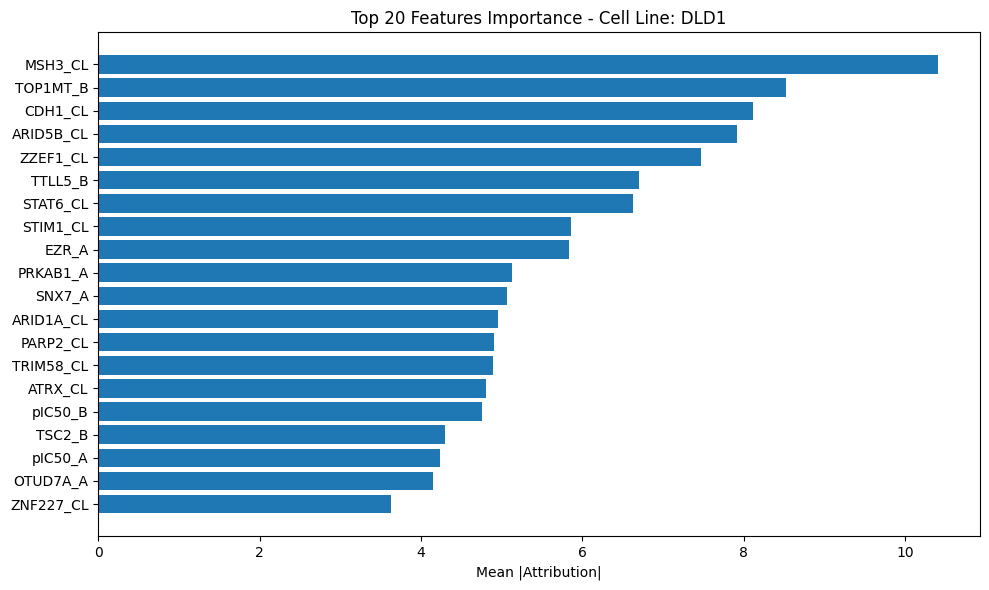

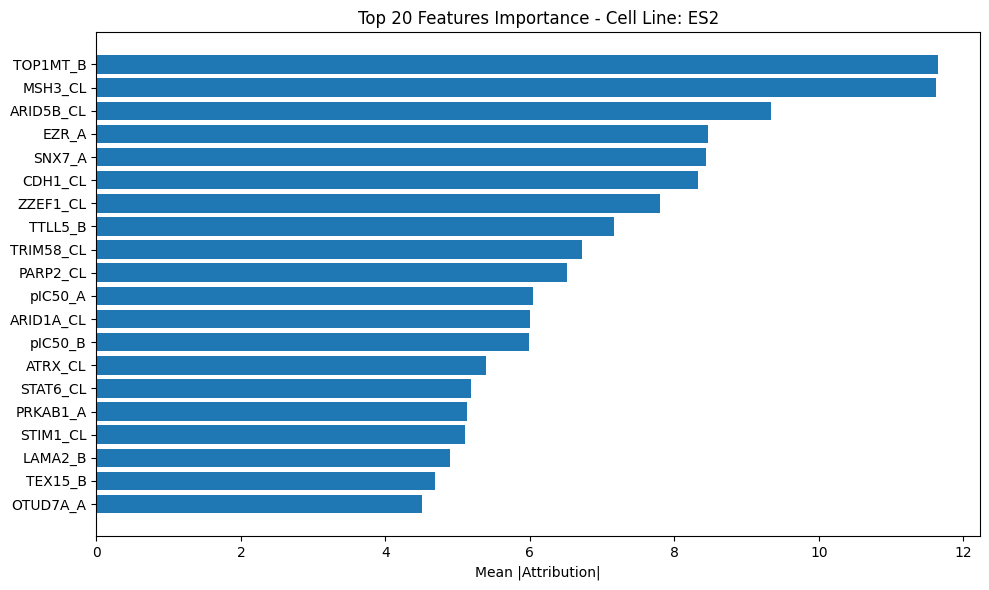

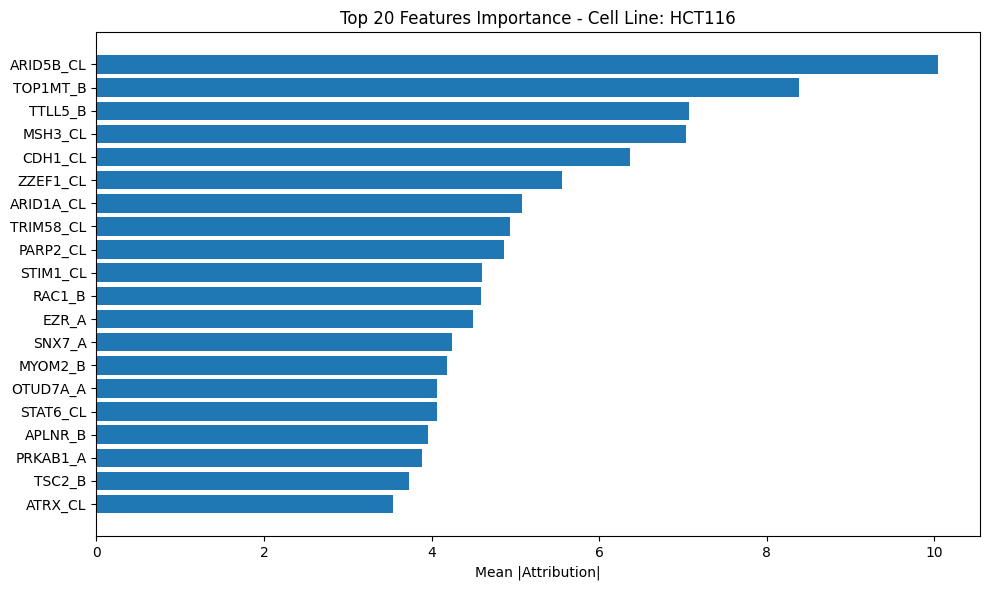

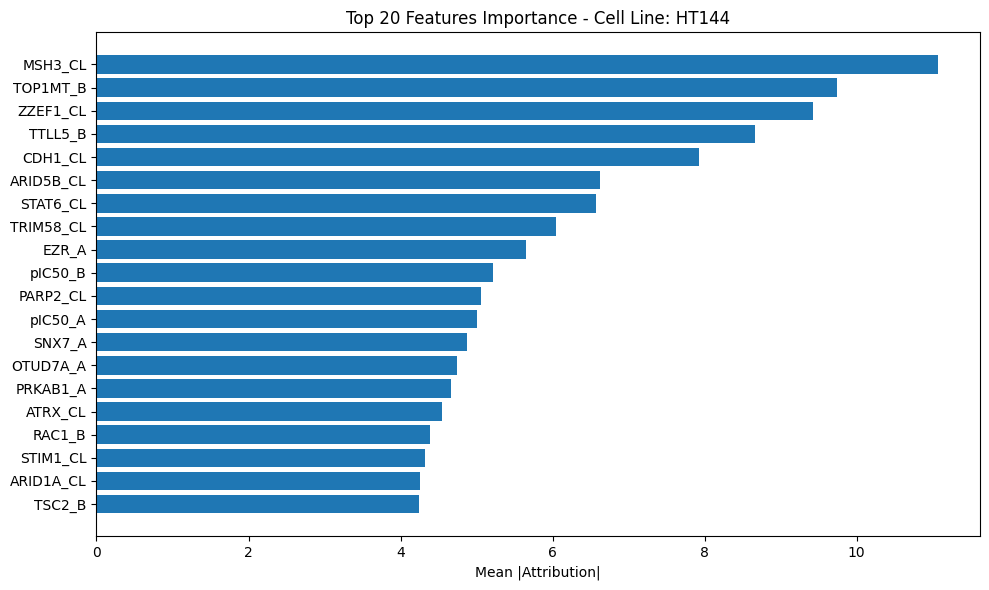

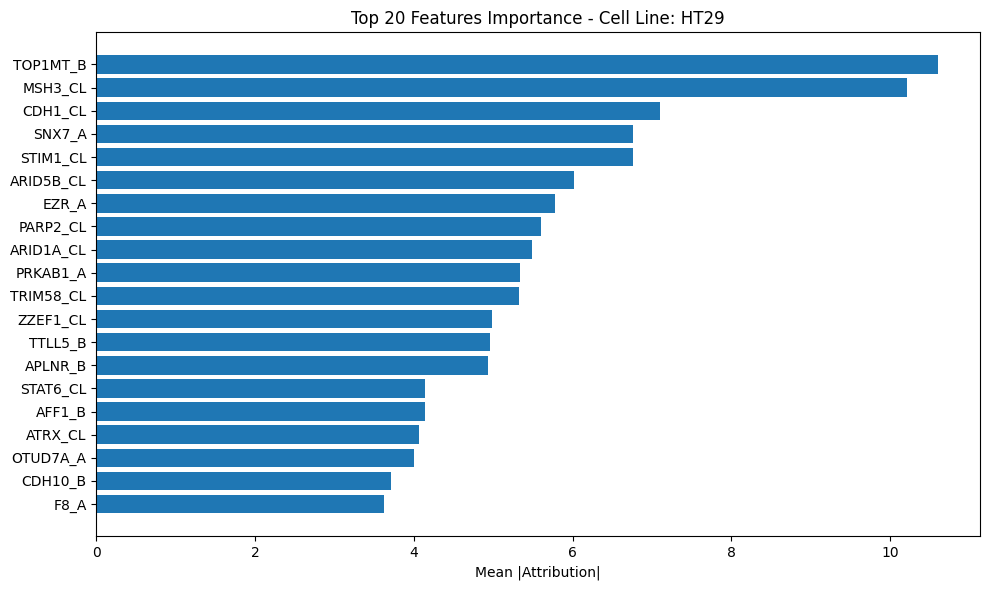

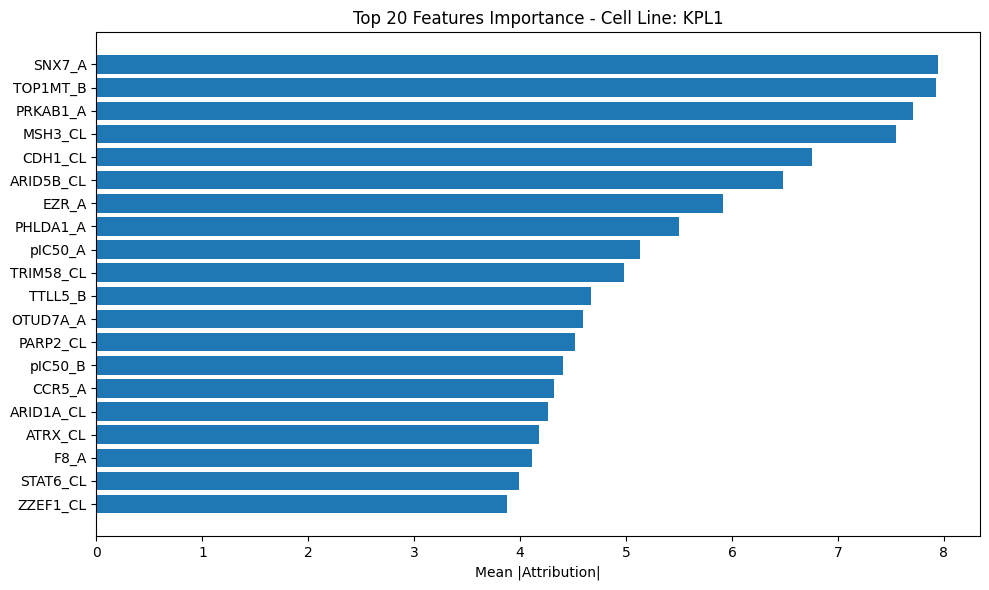

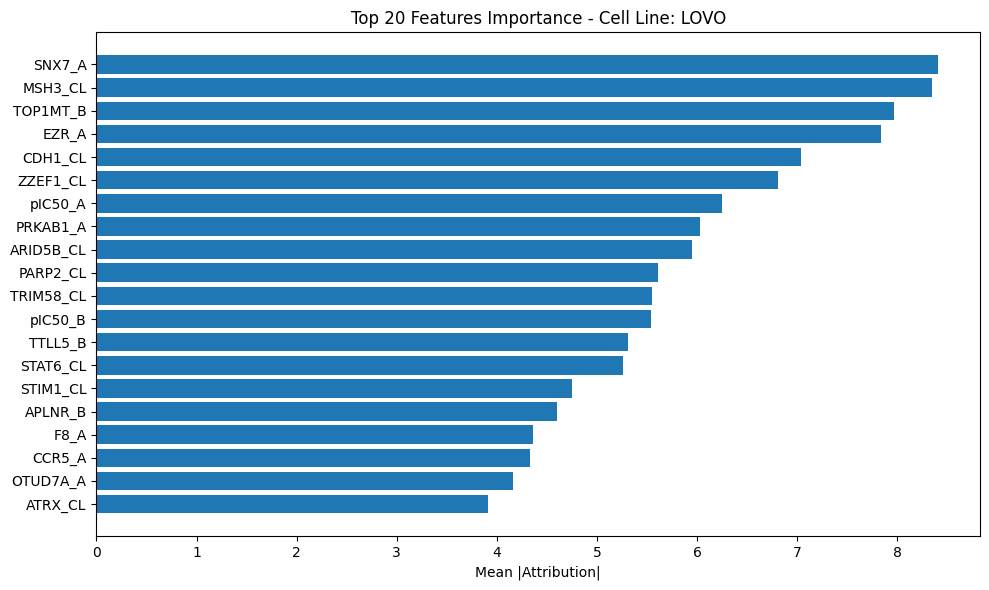

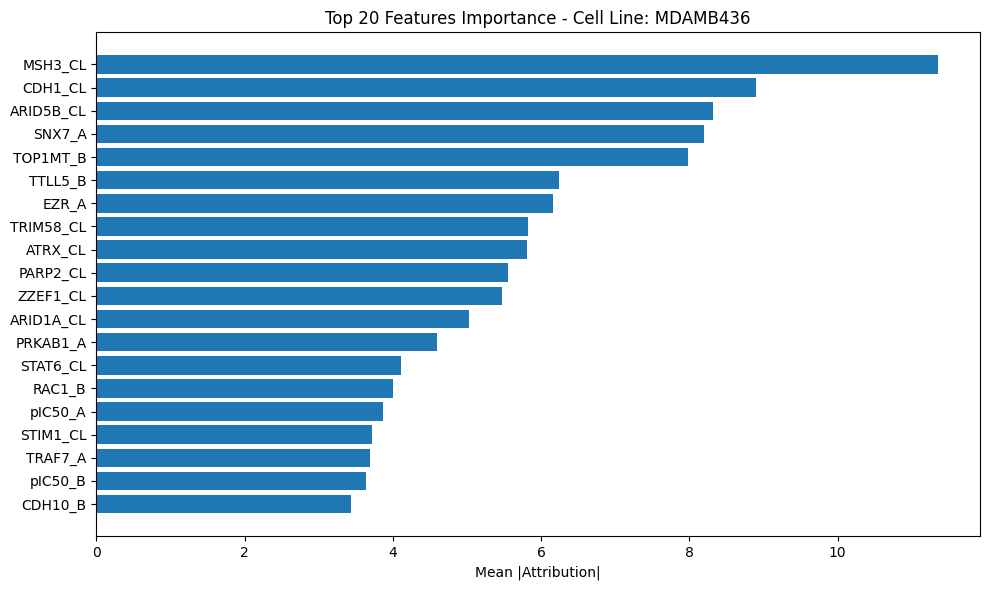

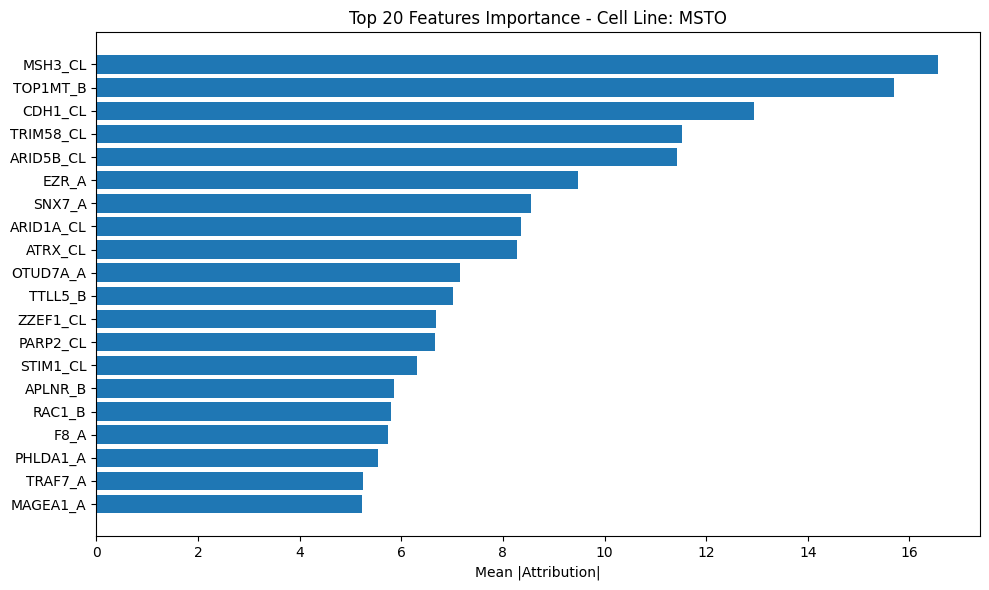

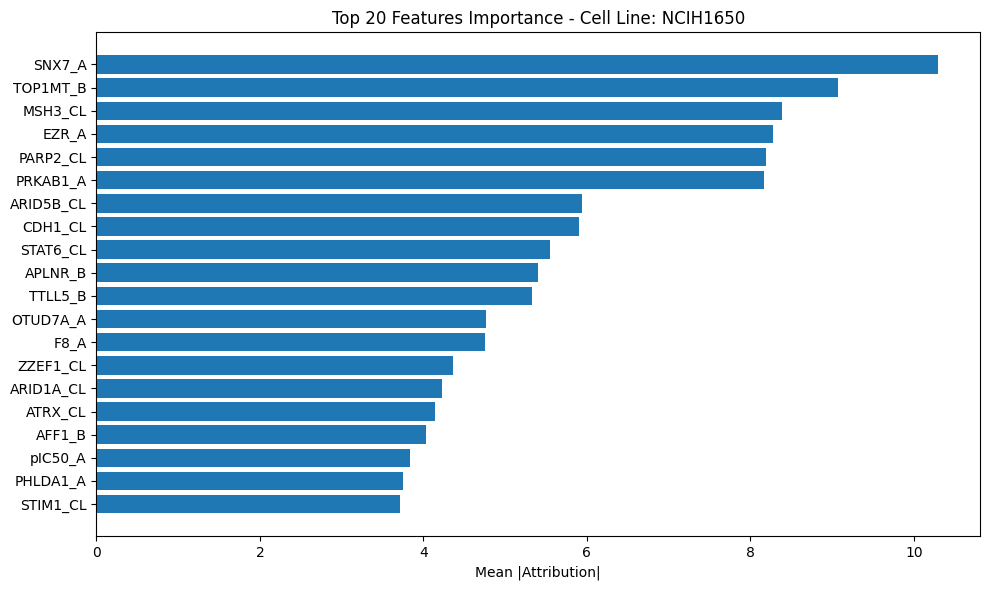

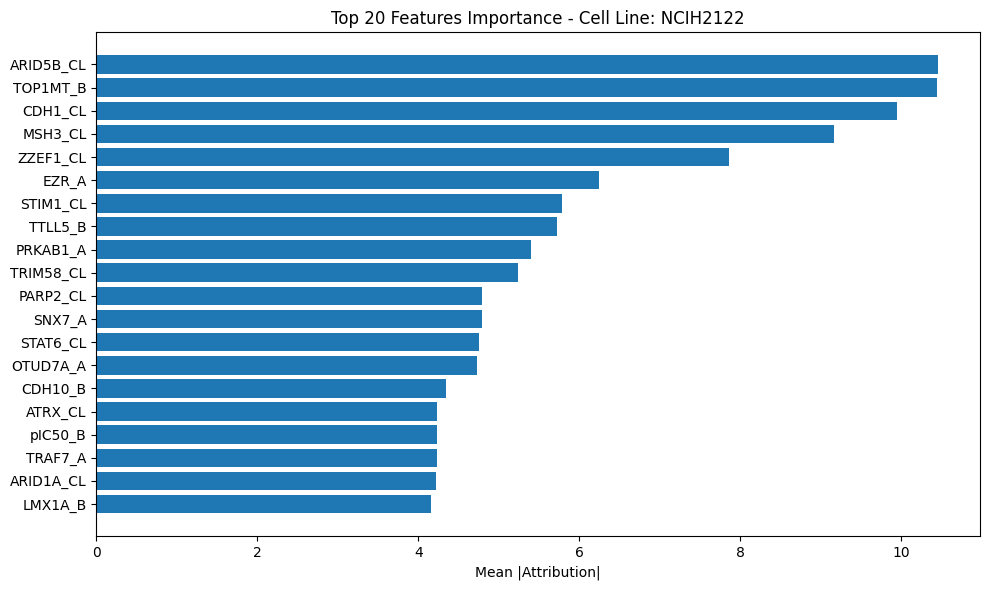

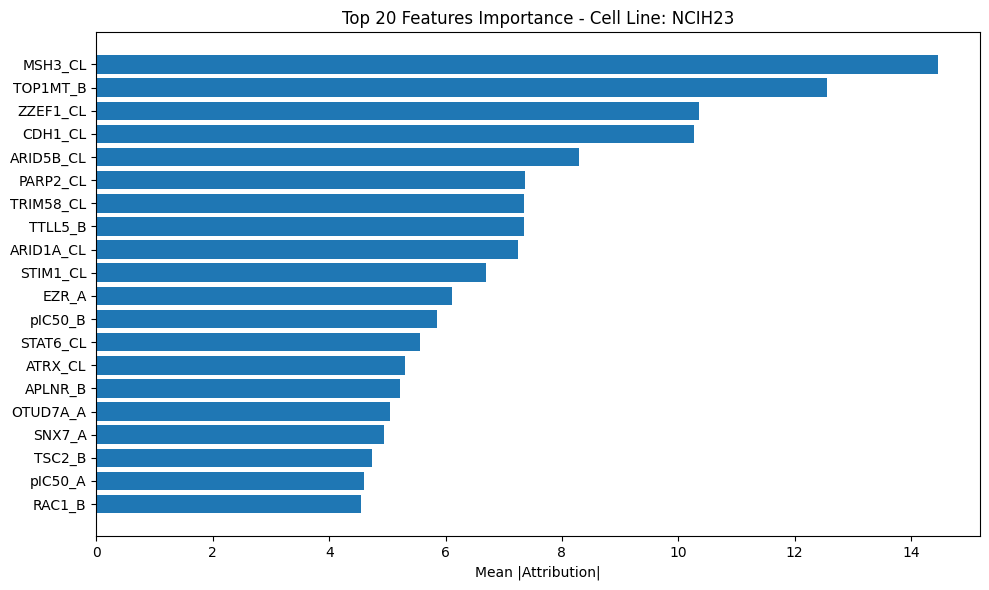

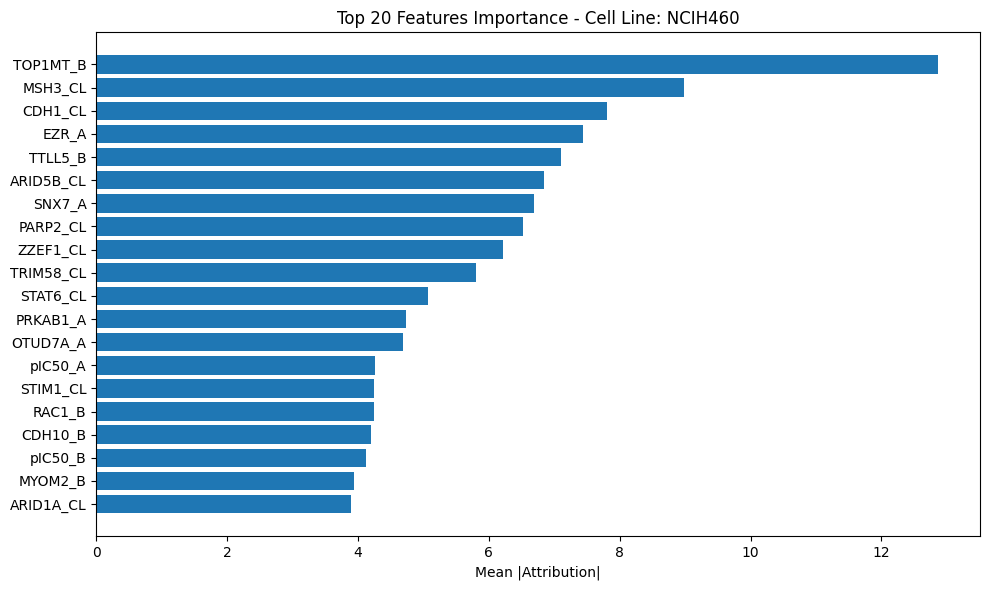

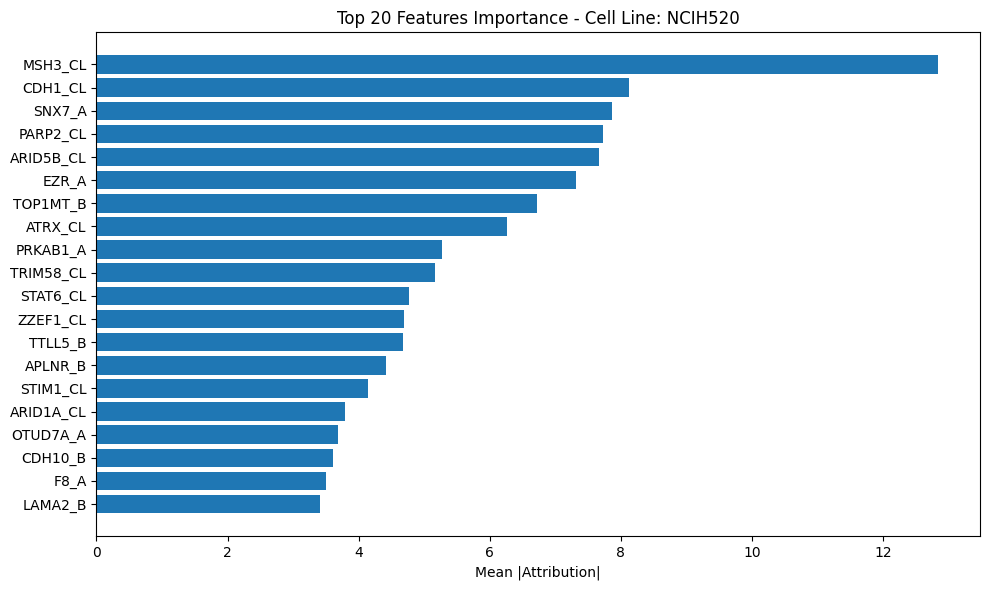

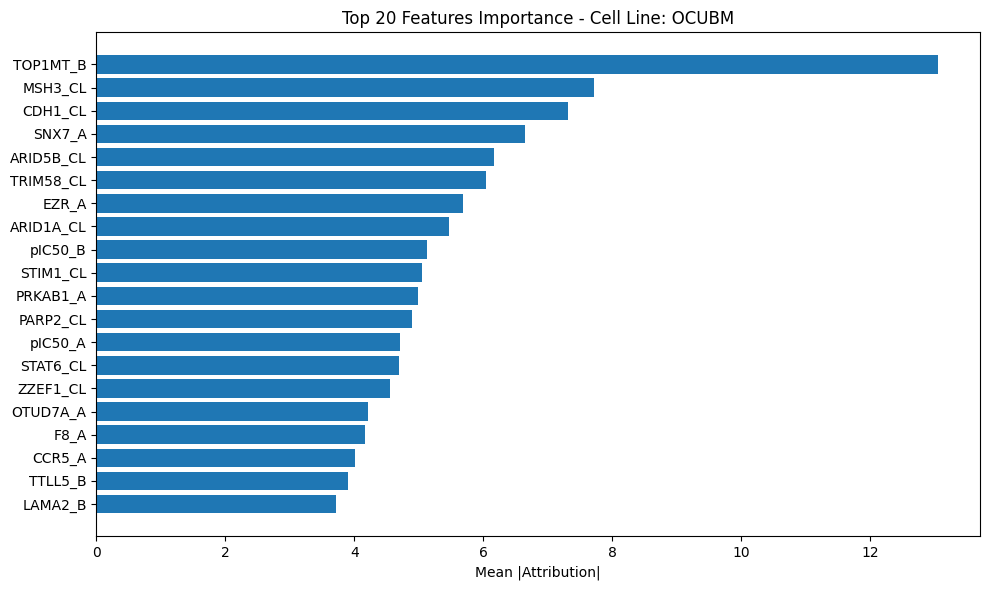

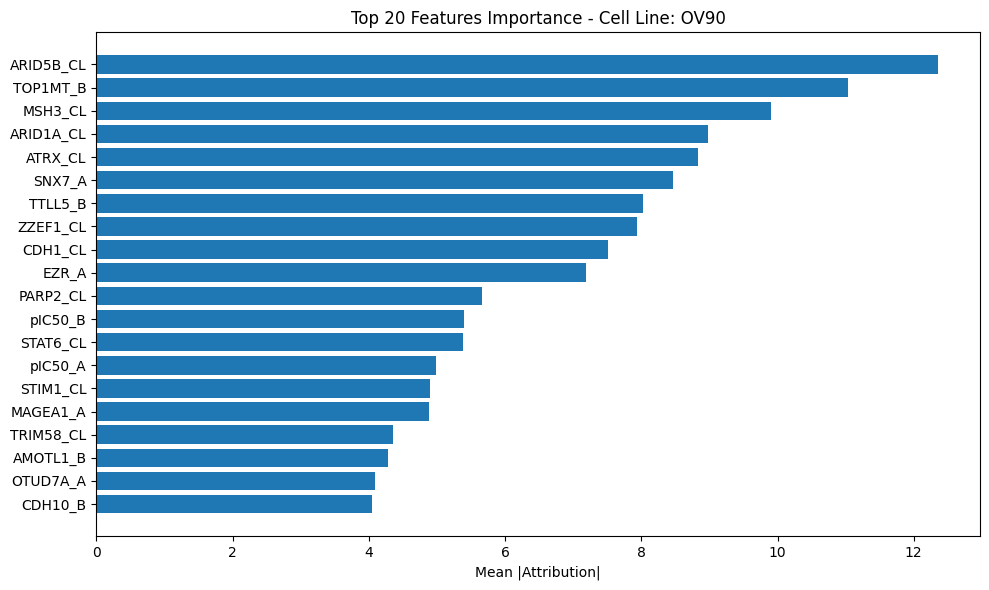

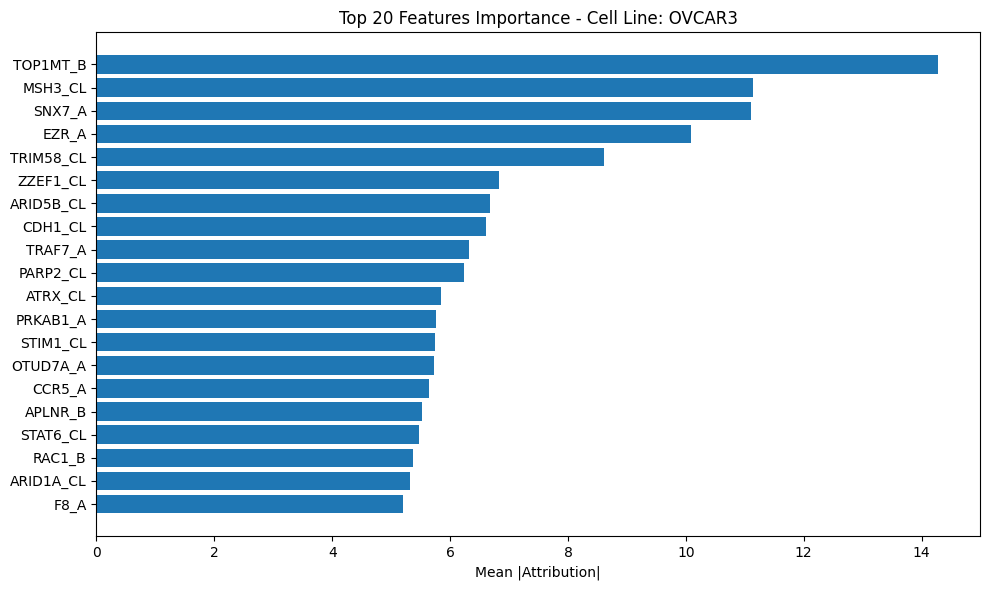

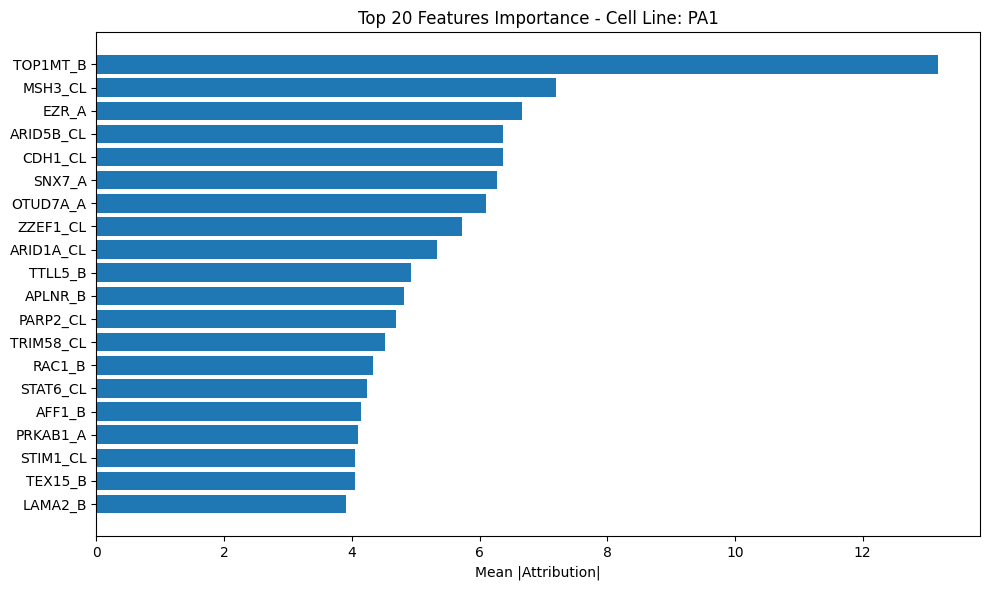

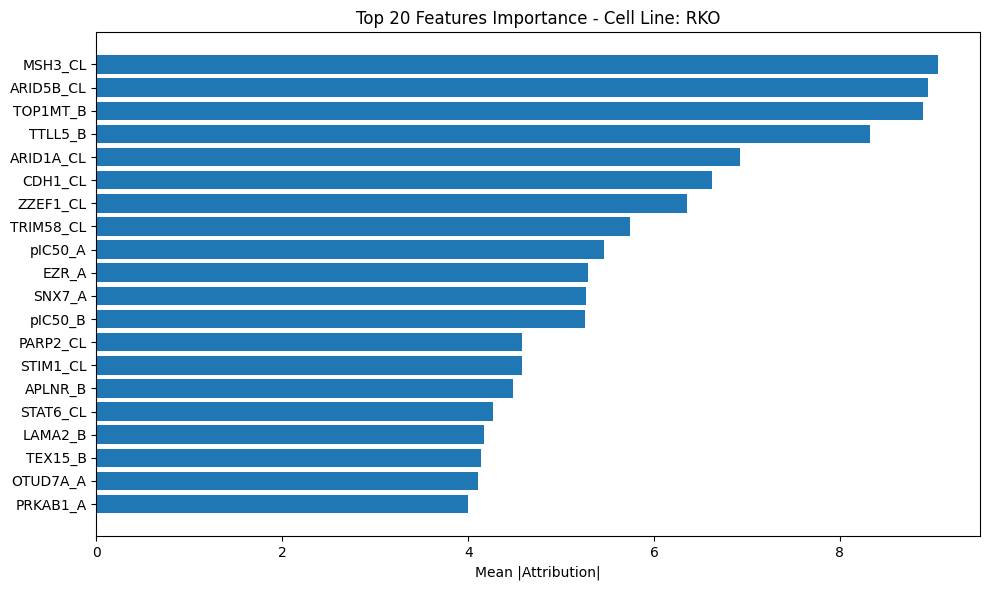

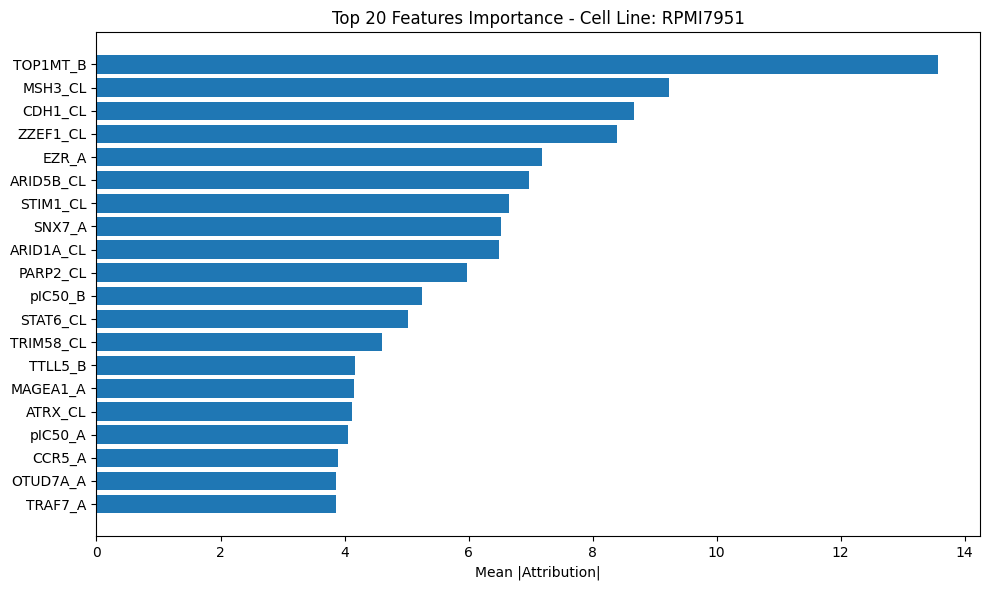

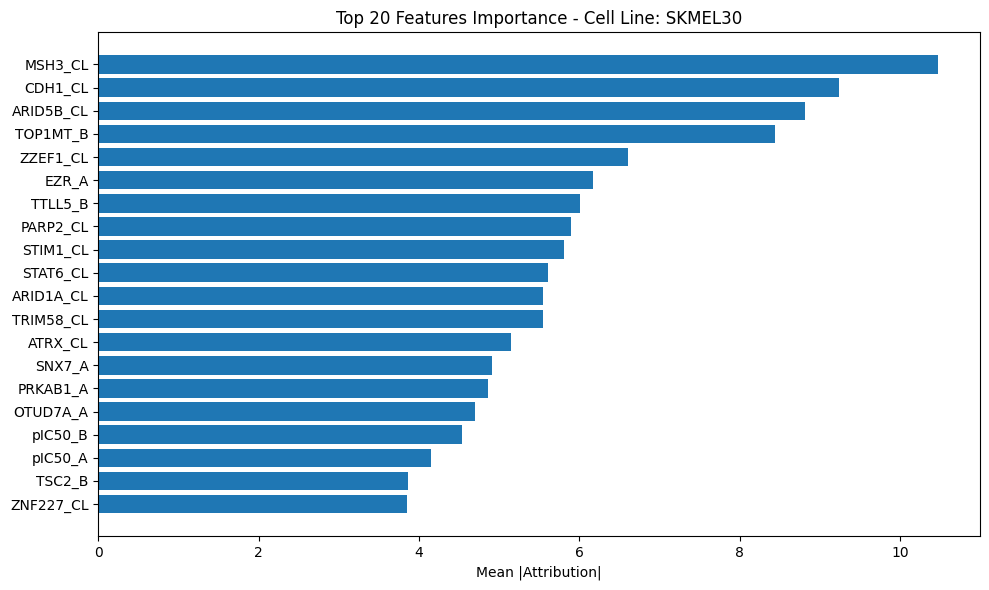

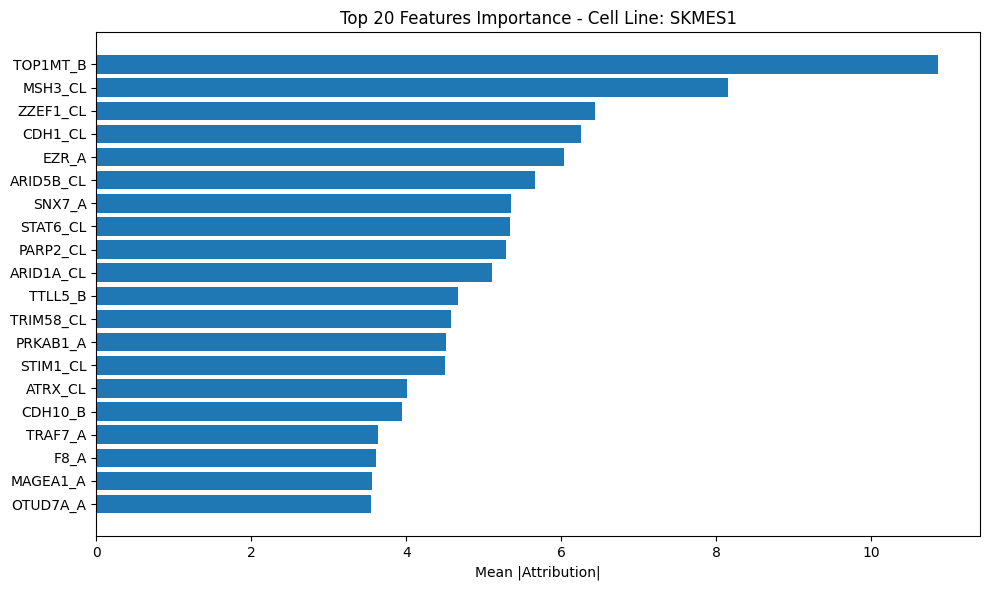

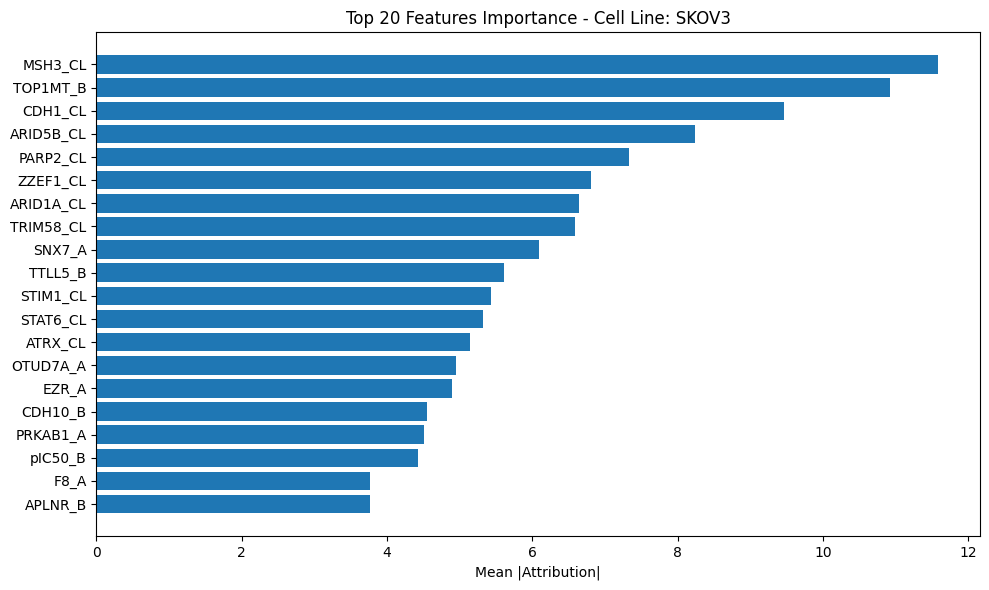

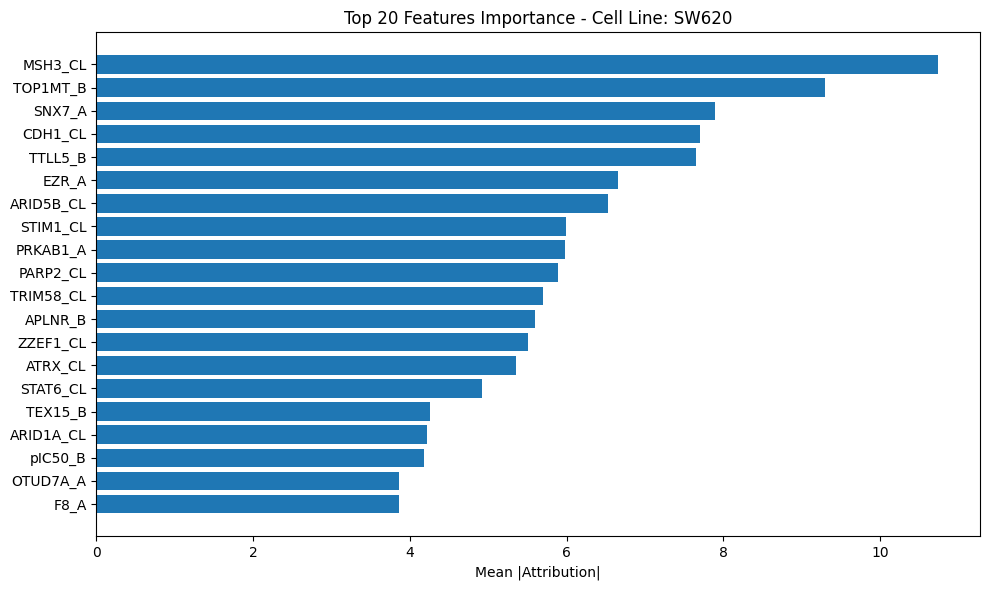

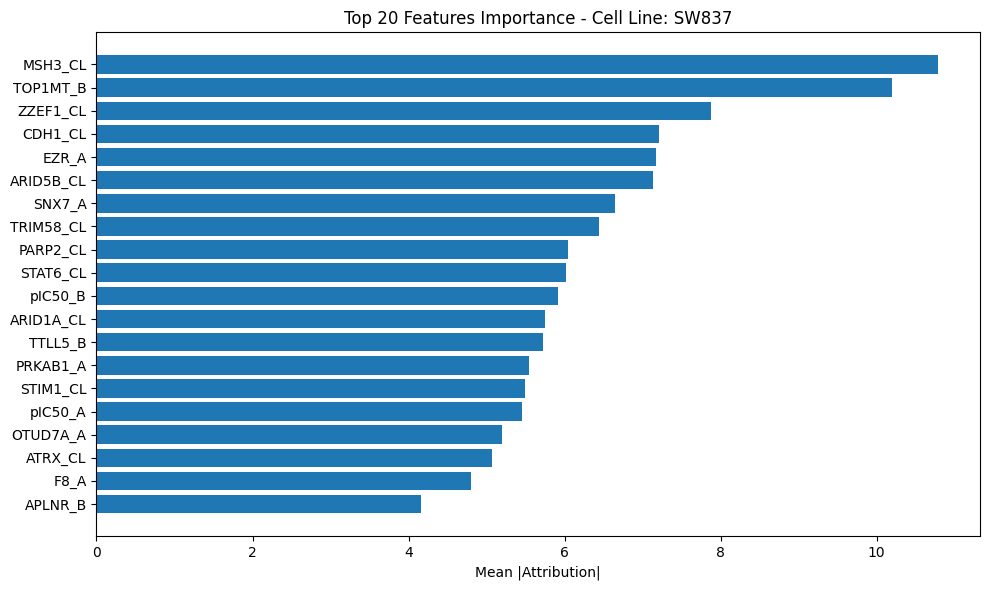

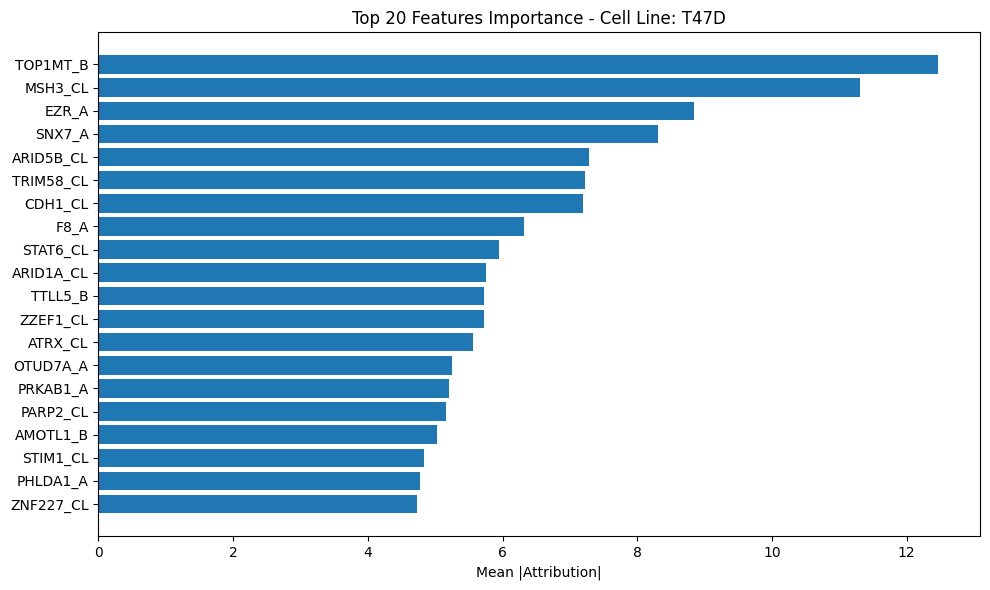

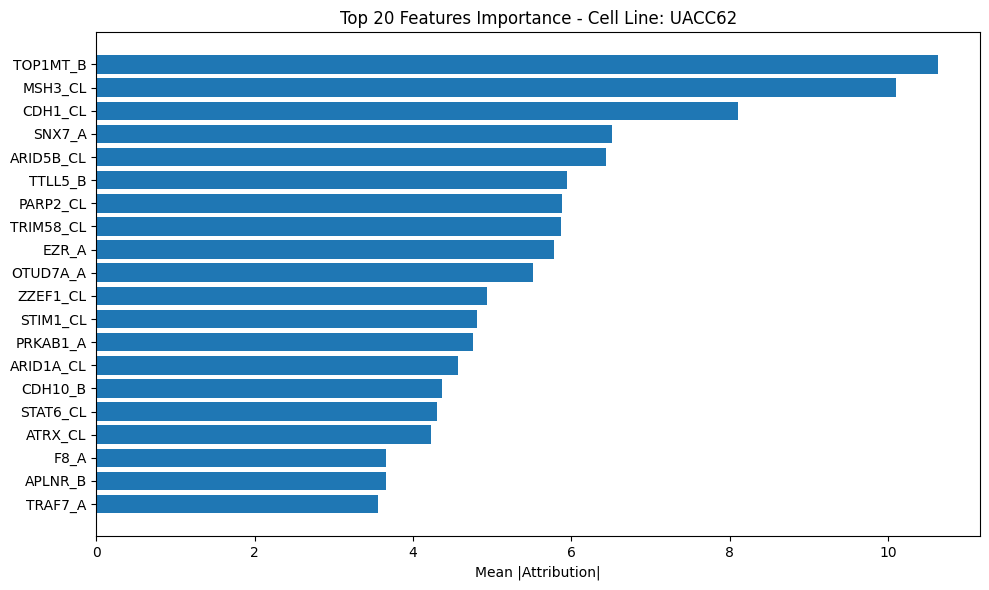

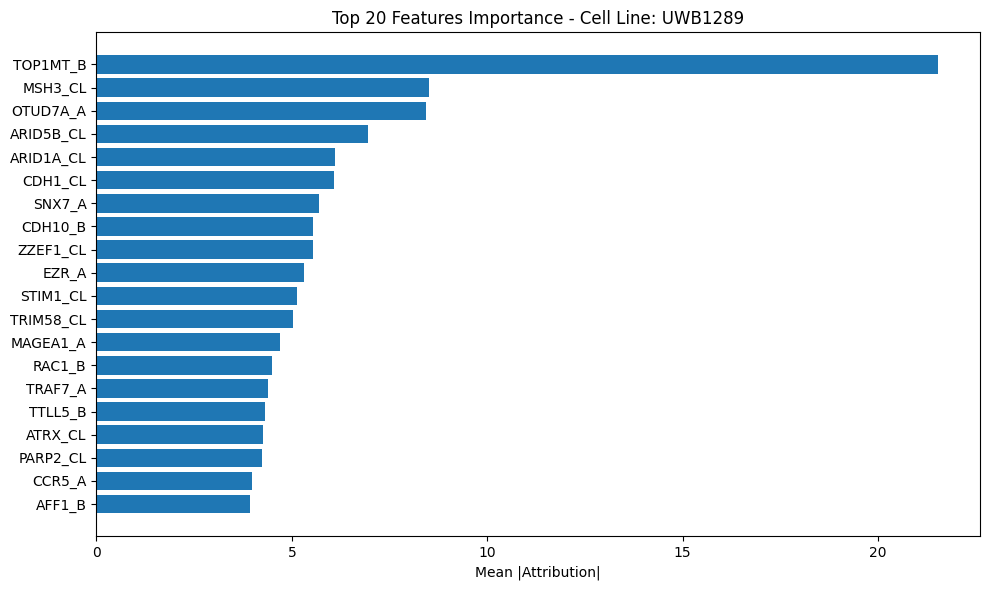

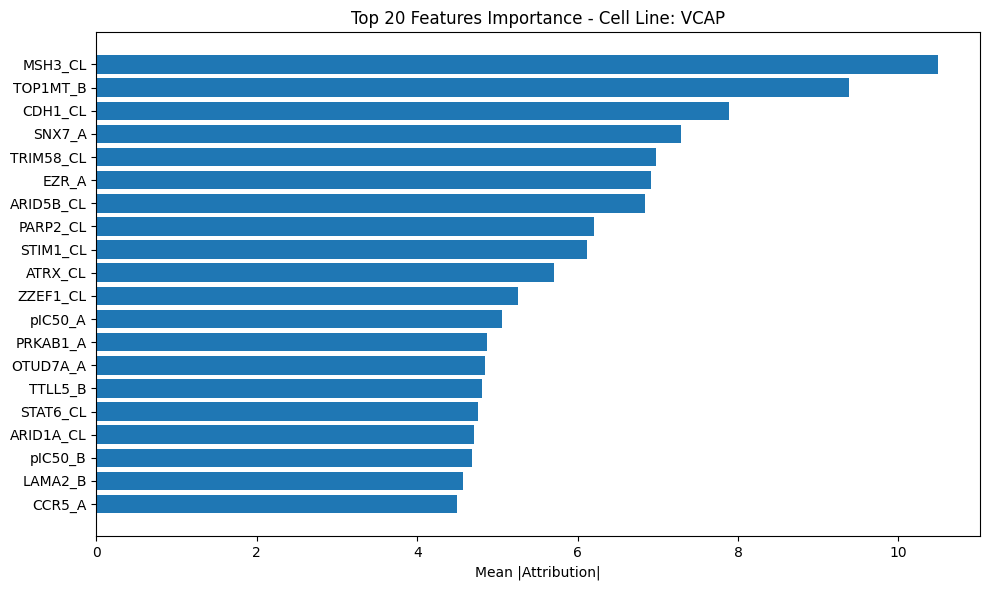

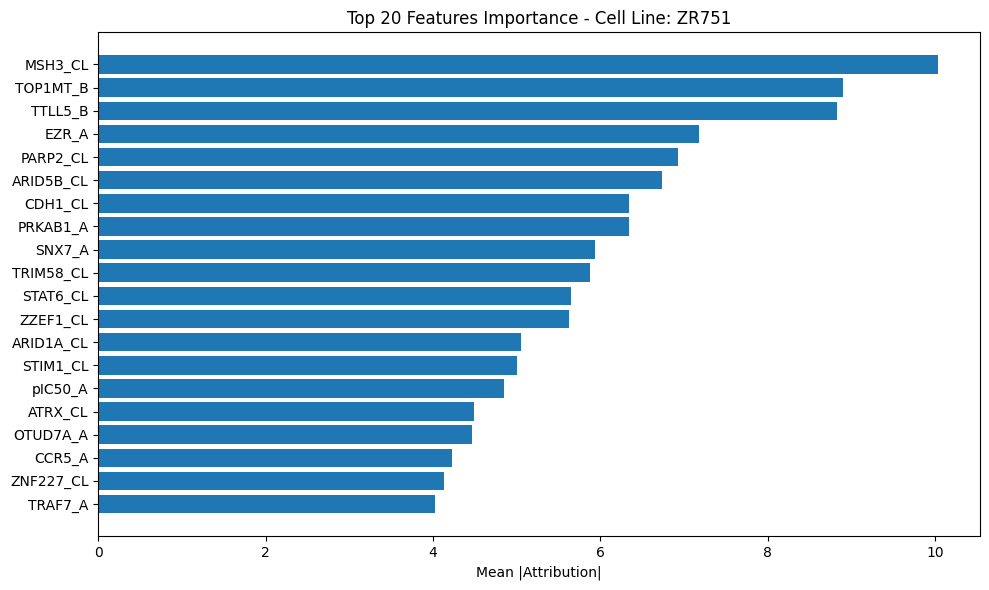

In [13]:
from explainability.data_utils import load_transynergy_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance_by_cell_line(all_attributions, feature_names, top_n=20):
    cell_lines = load_transynergy_cell_line_data(split='train')
    #permutation
    cell_lines = np.concatenate([cell_lines, cell_lines], axis=0)
    unique_cell_lines = np.unique(cell_lines)

    for cell_line in unique_cell_lines:
        cell_line_indices = np.where(cell_lines == cell_line)[0]
        cell_line_attributions = all_attributions[cell_line_indices]
        
        mean_abs_attributions = np.mean(np.abs(cell_line_attributions), axis=0)

        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_attribution": mean_abs_attributions
        }).sort_values(by="mean_abs_attribution", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_attribution"][::-1])
        plt.xlabel("Mean |Attribution|")
        plt.title(f"Top {top_n} Features Importance - Cell Line: {cell_line}")
        plt.tight_layout()
        plt.show()


# Reshape the channels into 1 and convert the attributions to a NumPy array for easier manipulation
N = all_attributions.shape[0]
attributions_reshaped = all_attributions.squeeze(1).reshape(N, -1)  
attributions_np = attributions_reshaped.numpy()

plot_feature_importance_by_cell_line(attributions_np, feature_name)
